In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import json
from datetime import datetime
import re
import csv
from bs4 import BeautifulSoup

In [2]:
def return_table(grid, id, company):
    for idx, each_grid in enumerate(grid, start=0):
        grid_a = each_grid.find_all(string = re.compile("A. A"))
        grid_p = each_grid.find_all(string = re.compile("A. E"))
        if  grid_a and grid_p:
            #print(idx,'combined BS', id, company)
            return None #grid[idx]
            break
        if grid_a:
            #print(idx,'Aktiv')
            #aktiv = grid[idx]
            aktiv = idx
            #print(get_total(aktiv))
            continue
        if grid_p:
            #print(idx,'Passiv')
            #passiv = grid[idx]
            passiv = idx
            #print(get_total(passiv))
            continue
        else:
            #return None
            continue
    try:
        #return aktiv, passiv
        return [aktiv, passiv]
    except:
        #print("None", id, company)
        return None 
    
#return_table(grid, id='x', company='xy')

In [3]:
def get_KPI(a, p):
    
    kpi = {
  "current_ratio": "",
  "qick_ratio": "",
  "cash_ratio": "",
  "debt2equity_ratio": "",
  "debt2asset_ratio": "",
  "equity_ratio": ""}
    
    kpi["assets"] = to_float(p['Gesamt'])
    kpi["equity"] = to_float(p['Eigenkapital'])
    kpi['current_ratio'] = current_ratio(a,p)
    kpi['qick_ratio'] = qick_ratio(a,p)
    kpi['cash_ratio'] = cash_ratio(a,p)
    kpi['debt2equity_ratio'] = debt2equity_ratio(a,p)
    kpi['debt2asset_ratio'] = debt2asset_ratio(a,p)
    kpi['equity_ratio'] = equity_ratio(a,p)
    
    return kpi


def current_ratio(aktiv, passiv):
    current_a = aktiv['Umlaufvermögen']
    current_l = passiv['Verbindlichkeiten_kurz']
    if current_l == '' :
        current_l = passiv['Verbindlichkeiten']
    ratio = to_float(current_a) / to_float(current_l)
    return ratio

def qick_ratio(aktiv, passiv):
    current_a = to_float(aktiv['Umlaufvermögen'])
    inventory = to_float(aktiv['Vorräte'])
    current_l = to_float(passiv['Verbindlichkeiten_kurz'])
    if current_l == 0 :
        current_l = to_float(passiv['Verbindlichkeiten'])
    ratio = ( current_a - inventory )  / current_l
    return ratio

def cash_ratio(aktiv, passiv):
    cash = to_float(aktiv['Guthaben'])
    current_l = to_float(passiv['Verbindlichkeiten_kurz'])
    if current_l == 0 :
        current_l = to_float(passiv['Verbindlichkeiten'])
    ratio = cash / current_l
    return ratio

def debt2equity_ratio(aktiv, passiv):
    liabilities = to_float(passiv['Verbindlichkeiten'])
    provisions = to_float(passiv['Rückstellungen'])
    accruals = to_float(passiv['Rechnungsabgrenzungsposten'])
    debt = liabilities + provisions + accruals
    equity = to_float(passiv['Eigenkapital'])
    ratio = debt / equity
    return ratio

def debt2asset_ratio(aktiv, passiv):
    liabilities = to_float(passiv['Verbindlichkeiten'])
    provisions = to_float(passiv['Rückstellungen'])
    accruals = to_float(passiv['Rechnungsabgrenzungsposten'])
    debt = liabilities + provisions + accruals
    total = to_float(passiv['Gesamt'])
    ratio = debt / total
    return ratio

def equity_ratio(aktiv, passiv):
    equity = to_float(passiv['Eigenkapital'])
    total = to_float(passiv['Gesamt'])
    ratio = equity / total
    return ratio

def to_float(a):
    a = a.replace('.','').replace(',','.')
    if a == '':
        a = 0
    return float(a) 

In [4]:
def aktiva_items(data):
    item_aktiva = {
  "Gesamt": "",
  "Anlagevermögen": "",
  "Umlaufvermögen": "",
  "Vorräte": "",
  "Guthaben": ""}
    
    for section in data.find_all('tbody'):
        last_row = section.find_all('tr')[-1:]
        item_aktiva["Gesamt"] = last_row[0].find_all('td')[1].text.strip()

        for line in section.find_all('tr')[:-1]:
            cell_data = []
            for idx, cell in enumerate(line.find_all('td'), start=1):
                cell = cell.text
                if idx == 1:
                    name = cell.split(" ")[1].strip()
                if idx == 2 and "anlagevermögen" in name.lower():
                    item_aktiva["Anlagevermögen"] = cell
                if idx == 2 and "umlaufvermögen" in name.lower():
                    item_aktiva["Umlaufvermögen"] = cell
                if idx == 2 and "vorräte" in name.lower():
                    item_aktiva["Vorräte"] = cell
                if idx == 2 and re.search(r'(kassen|guthaben)', name.lower()):
                    item_aktiva["Guthaben"] = cell
    return(item_aktiva)

def passiva_items(data):
    item_passiva = {
  "Gesamt": "",
  "Eigenkapital": "",
  "Rückstellungen": "",
  "Rechnungsabgrenzungsposten": "",
  "Verbindlichkeiten": "",
  "Verbindlichkeiten_kurz": ""}
    
    for section in data.find_all('tbody'):
        last_row = section.find_all('tr')[-1:]
        item_passiva["Gesamt"] = last_row[0].find_all('td')[1].text.strip()

        for line in section.find_all('tr')[:-1]:
            cell_data = []
            for idx, cell in enumerate(line.find_all('td'), start=1):
                cell = cell.text
                if idx == 1:
                    name = cell.split(" ")[1].strip()
                    full = cell.strip()
                if idx == 2 and "eigenkapital" in name.lower():
                    item_passiva["Eigenkapital"] = cell
                if idx == 2 and "rückstellungen" in name.lower():
                    item_passiva["Rückstellungen"] = cell
                if idx == 2 and "rechnungsabgrenzungsposten" in name.lower():
                    item_passiva["Rechnungsabgrenzungsposten"] = cell
                if idx == 2 and "verbindlichkeiten" in name.lower():
                    item_passiva["Verbindlichkeiten"] = cell
                if idx == 2 and "laufzeit bis" in full.lower():
                    item_passiva["Verbindlichkeiten_kurz"] = cell

    return(item_passiva)

In [7]:
import aiofiles
import asyncio
import json
from pathlib import Path
import nest_asyncio

In [8]:
nest_asyncio.apply()

In [9]:
directory = 'data/financial_information'

In [16]:
async def read_data(filename, sem):
    all_level_1 = []
    async with sem:
        # Read the contents of the json file.
        async with aiofiles.open(f'{directory}/{filename}', mode='r') as f:
            contents = await f.read()

        # Load it into a dictionary and create a list.
        data = json.loads(contents)

        for idx, val in enumerate(data.keys(), start=1):
            
            try:
                if "Konzernabschluss" in val: continue
                if "\u00a7\u00a7 264 Abs. 3" in val: continue
                if val == "": continue
                company = data[val]['company']
                year = re.split(" " , data[val]['name'])[-1]
                report = data[val]['report']
                soup = BeautifulSoup(report, 'html.parser')
                grid = soup.findAll('table', attrs={"class":"std_table"})
                a = return_table(grid, idx, company)
                aktiv, passiv = grid[a[0]], grid[a[1]]
                
                kpi = get_KPI(aktiva_items(aktiv), passiva_items(passiv)) 

                export = [company, 
                            year , 
                            kpi["assets"] , 
                            kpi["equity"], 
                            kpi["current_ratio"],
                            kpi["qick_ratio"],
                            kpi["cash_ratio"],
                            kpi["debt2equity_ratio"],
                            kpi["debt2asset_ratio"],
                            kpi["equity_ratio"]]
                                                
                all_level_1.append(export)
                 
            except Exception as f:
                pass
        return all_level_1

async def main():
    sem = asyncio.Semaphore(50) # Allow 1000 concurrent readers
    pathlist = Path(directory).glob('*.json')
    pathlist = list(pathlist)#[0:100]
    # A list to be populated with async tasks.
    tasks = []

    # Iterate through all json files in the directory.
    for path in pathlist:

        tasks.append(asyncio.create_task(read_data(path.name, sem)))

    return await asyncio.gather(*tasks)

kpi_list_1 = asyncio.run(main())

In [ ]:
all_stations = []
for stations in kpi_list_1:
    for station in stations:
        all_stations.append(station)
all_stations      

In [ ]:
import pandas as pd

In [23]:
pd.DataFrame(all_stations)

,0,1,2,3,4,5,6,7,8,9
0,aerovita Medizintechnik GmbH,31.12.2021,2542340.56,998695.31,3.054492,1.909556,0.266224,1.545662,0.607175,0.392825
1,aerovita Medizintechnik GmbH,31.12.2020,2221592.19,844349.69,1.581423,0.910619,0.001764,1.631128,0.619935,0.380065
2,aerovita Medizintechnik GmbH,31.12.2019,1846181.73,631658.62,0.974283,0.519850,0.001492,1.922752,0.657857,0.342143
3,aerovita Medizintechnik GmbH,31.12.2018,1575596.88,392798.47,0.888383,0.389229,0.004439,3.011209,0.750699,0.249301
4,TAN GUN Sports GmbH,31.12.2019,28764.42,12072.21,2.170783,2.170783,0.000000,1.382697,0.580308,0.419692
...,...,...,...,...,...,...,...,...,...,...
72119,Balance Fitness GmbH,31.12.2017,432241.07,173060.23,2.657882,2.575991,0.170556,1.497634,0.599621,0.400379
72120,PEAK Hospitality GmbH,31.12.2020,1857877.75,262016.59,0.863429,0.863429,0.008808,6.090687,0.858970,0.141030
72121,PEAK Hospitality GmbH,31.12.2019,900435.91,124201.64,0.436137,0.436137,0.019165,6.249791,0.862065,0.137935
72122,Elektrotechnik Wettin GmbH,31.12.2019,1774127.03,114793.60,1.091546,0.336515,0.006104,14.454930,0.935296,0.064704


In [21]:
async def parse_year(data, val, idx):  
            try:
                if "Konzernabschluss" in val: return
                if "\u00a7\u00a7 264 Abs. 3" in val: return
                if val == "": return
                company = data[val]['company']
                year = re.split(" " , data[val]['name'])[-1]
                report = data[val]['report']
                soup = BeautifulSoup(report, 'html.parser')
                grid = soup.findAll('table', attrs={"class":"std_table"})
                a = return_table(grid, idx, company)
                aktiv, passiv = grid[a[0]], grid[a[1]]
                
                kpi = get_KPI(aktiva_items(aktiv), passiva_items(passiv)) 

                export = [company, 
                            year , 
                            kpi["assets"] , 
                            kpi["equity"], 
                            kpi["current_ratio"],
                            kpi["qick_ratio"],
                            kpi["cash_ratio"],
                            kpi["debt2equity_ratio"],
                            kpi["debt2asset_ratio"],
                            kpi["equity_ratio"]]
                                                
                return export
                
            except Exception as f:
                pass

async def read_data(filename, sem):
    async with sem:
        # Read the contents of the json file.
        async with aiofiles.open(f'{directory}/{filename}', mode='r') as f:
            contents = await f.read()

        # Load it into a dictionary and create a list.
        data = json.loads(contents)
        inner_tasks = []
            
        for idx, val in enumerate(data.keys(), start=1):
            nest_asyncio.apply()
            #inner_task = asyncio.create_task(parse_year(data, val, idx))
            inner_tasks.append(asyncio.create_task(parse_year(data, val, idx)))

        inner_list = await asyncio.gather(*inner_tasks)
        return inner_list

async def main():
    N = 10
    sem = asyncio.Semaphore(N) # Allow 1000 concurrent readers
    pathlist = Path(directory).glob('*.json')
    pathlist = list(pathlist)[0:10]
    # A list to be populated with async tasks.
    tasks = []

    # Iterate through all json files in the directory.
    for path in pathlist:
        tasks.append(asyncio.create_task(read_data(path.name, sem)))

    company_list = await asyncio.gather(*tasks)
    return company_list

kpi_list_2 = asyncio.run(main())

In [ ]:
kpi_list_2

In [42]:
pd.DataFrame(kpi_list_1)

,0,1,2,3,4
0,"[aerovita Medizintechnik GmbH, 31.12.2021, 254...","[aerovita Medizintechnik GmbH, 31.12.2020, 222...","[aerovita Medizintechnik GmbH, 31.12.2019, 184...","[aerovita Medizintechnik GmbH, 31.12.2018, 157...",None
1,"[TAN GUN Sports GmbH, 31.12.2019, 28764.42, 12...","[TAN GUN Sports GmbH, 31.12.2018, 34681.73, 18...","[TAN GUN Sports GmbH, 31.12.2017, 33535.56, 98...",None,None
2,"[Cine plus Mediaservice GmbH & Co. KG, 31.12.2...","[Cine plus Mediaservice GmbH & Co. KG, 31.12.2...","[Cine plus Mediaservice GmbH & Co. KG, 31.12.2...","[Cine plus Mediaservice GmbH & Co. KG, 31.12.2...",None
3,"[Plaza Carree Hotel GmbH, 31.12.2021, 2491152....","[Plaza Carree Hotel GmbH, 31.12.2020, 2233802....","[Plaza Carree Hotel GmbH, 31.12.2019, 1595263....","[Plaza Carree Hotel GmbH, 31.12.2018, 1588690....",None
4,"[IP innovativ Personal GmbH, 31.12.2021, 35454...","[IP innovativ Personal GmbH, 31.12.2020, 33483...","[IP innovativ Personal GmbH, 31.12.2019, 23535...","[IP innovativ Personal GmbH, 31.12.2018, 22441...","[IP innovativ Personal GmbH, 31.12.2017, 19366..."
...,...,...,...,...,...
95,"[ZMF Event GmbH, 31.12.2019, 565932.66, 186589...","[ZMF Event GmbH, 31.12.2018, 358765.17, 129785...","[ZMF Event GmbH, 31.12.2017, 196273.62, 51701....",None,None
96,"[Femme Mode GmbH, 31.12.2020, 466770.57, 11088...","[Femme Mode GmbH, 31.12.2019, 422790.74, 17486...","[Femme Mode GmbH, 31.12.2018, 333014.15, 17463...","[Femme Mode GmbH, 31.12.2017, 291020.78, 17272...",None
97,"[Crombeen GmbH, 31.12.2021, 5318658.36, 140272...","[Crombeen GmbH, 31.12.2020, 3584113.62, 720131...","[Crombeen GmbH, 31.12.2019, 2351487.68, 769212...","[Crombeen GmbH, 31.12.2018, 2132129.51, 563197...","[Crombeen GmbH, 31.12.2017, 1757058.37, 341725..."
98,"[Schnurr Reisen GmbH, 31.12.2021, 2384522.6, 2...","[Schnurr Reisen GmbH, 31.12.2020, 2398594.68, ...","[Schnurr Reisen GmbH, 31.12.2019, 2307160.73, ...",None,None


In [15]:
print(all_level_1)

[['HGH Hotelgesellschaft mbH', '31.12.2018', 7335461.86, 48222.21, 1.7902713550215776, 1.5453155566913481, 0.7122974779533259, 151.11791122804203, 0.9934261521741454, 0.006573847825854553], ['Zillertal GmbH', '31.12.2020', 7607535.72, 4841744.7, 1.9104929267569524, 1.909974588744426, 0.4185335857570342, 0.5712385083005306, 0.3635593866130411, 0.6364406133869589], ['Zillertal GmbH', '31.12.2019', 8505349.91, 5265088.15, 1.3420728229408574, 1.3412684421818197, 0.4218752612345415, 0.6154240285606614, 0.3809674844994119, 0.619032515500588], ['Zillertal GmbH', '31.12.2018', 8805104.33, 5212040.17, 1.1594189609128807, 1.1594189609128807, 0.3575356627472136, 0.6893776799114731, 0.4080660518420002, 0.5919339481579998], ['Zillertal GmbH', '31.12.2017', 9332628.29, 5201623.56, 1.1103602438829314, 1.1103602438829314, 0.3353671290472825, 0.794176026455863, 0.44264108690864834, 0.5573589130913517], ['Musikreisen Manufaktur GmbH', '30.06.2021', 1138757.98, 467486.66, 23.451251425184857, 23.451251425

In [30]:
all_kpi = pd.DataFrame(all_level_1)
all_kpi[1] = all_kpi[1].replace(to_replace='[0-9]{2}.[0-9]{2}.', regex=True, value='')
all_kpi

,0,1,2,3,4,5,6,7,8,9
0,HGH Hotelgesellschaft mbH,2018,7335461.86,48222.21,1.790271,1.545316,0.712297,151.117911,0.993426,0.006574
1,Zillertal GmbH,2020,7607535.72,4841744.70,1.910493,1.909975,0.418534,0.571239,0.363559,0.636441
2,Zillertal GmbH,2019,8505349.91,5265088.15,1.342073,1.341268,0.421875,0.615424,0.380967,0.619033
3,Zillertal GmbH,2018,8805104.33,5212040.17,1.159419,1.159419,0.357536,0.689378,0.408066,0.591934
4,Zillertal GmbH,2017,9332628.29,5201623.56,1.110360,1.110360,0.335367,0.794176,0.442641,0.557359
...,...,...,...,...,...,...,...,...,...,...
72119,Möschlitzer Agrar GmbH,2020,8402715.90,1899137.08,0.543835,0.487114,0.061558,3.306814,0.747388,0.226015
72120,Möschlitzer Agrar GmbH,2018,5554190.75,2448336.57,0.388395,0.253395,0.122428,1.141255,0.503075,0.440809
72121,Milchproduktion Kreinitz GmbH,2021,4091273.46,175280.62,0.912292,0.566302,0.000103,22.341277,0.957157,0.042843
72122,Milchproduktion Kreinitz GmbH,2020,3775670.36,595.07,0.777396,0.534706,0.000456,6343.918010,0.999842,0.000158


In [17]:
all_kpi[1] = all_kpi[1].apply(int)
kpi_1920 = all_kpi.loc[all_kpi[1].between(2019,2020)]
kpi_1920 = kpi_1920.groupby(0).filter(lambda x : len(x)==2)
#kpi_1920 = kpi_1920[kpi_1920[0].duplicated(keep=False)]

In [19]:
kpi_1920

,0,1,2,3,4,5,6,7,8,9
1,Zillertal GmbH,2020,7607535.72,4841744.70,1.910493,1.909975,0.418534,0.571239,0.363559,0.636441
2,Zillertal GmbH,2019,8505349.91,5265088.15,1.342073,1.341268,0.421875,0.615424,0.380967,0.619033
11,SeaTravel HAM Kreuzfahrten GmbH,2020,757140.20,124036.25,1.171091,1.137893,0.019128,5.104185,0.836178,0.163822
12,SeaTravel HAM Kreuzfahrten GmbH,2019,764457.78,106369.15,1.001649,0.950384,0.021718,6.186837,0.860857,0.139143
16,Arcade-Hostel GmbH,2020,390262.52,1193.20,0.154975,0.153960,0.001406,326.072176,0.996943,0.003057
17,Arcade-Hostel GmbH,2019,430010.06,59938.92,0.298675,0.297298,0.233645,6.174138,0.860610,0.139390


In [20]:
kpi_1920.reset_index()

,index,0,1,2,3,4,5,6,7,8,9
0,1,Zillertal GmbH,2020,7607535.72,4841744.70,1.910493,1.909975,0.418534,0.571239,0.363559,0.636441
1,2,Zillertal GmbH,2019,8505349.91,5265088.15,1.342073,1.341268,0.421875,0.615424,0.380967,0.619033
2,11,SeaTravel HAM Kreuzfahrten GmbH,2020,757140.20,124036.25,1.171091,1.137893,0.019128,5.104185,0.836178,0.163822
3,12,SeaTravel HAM Kreuzfahrten GmbH,2019,764457.78,106369.15,1.001649,0.950384,0.021718,6.186837,0.860857,0.139143
4,16,Arcade-Hostel GmbH,2020,390262.52,1193.20,0.154975,0.153960,0.001406,326.072176,0.996943,0.003057
5,17,Arcade-Hostel GmbH,2019,430010.06,59938.92,0.298675,0.297298,0.233645,6.174138,0.860610,0.139390


In [23]:
kpi_adj = all_kpi[all_kpi[4] > 0 ]
kpi_adj = kpi_adj[kpi_adj[4] < 15 ]
kpi_adj = kpi_adj[kpi_adj[5] > 0 ]
kpi_adj = kpi_adj[kpi_adj[5] < 19 ]
kpi_adj = kpi_adj[kpi_adj[6] > 0 ]
kpi_adj = kpi_adj[kpi_adj[6] < 4 ]
kpi_adj = kpi_adj[kpi_adj[7] > 0 ]
kpi_adj = kpi_adj[kpi_adj[7] < 50 ]
kpi_adj

,0,1,2,3,4,5,6,7,8,9
1,Zillertal GmbH,2020,7607535.72,4841744.70,1.910493,1.909975,0.418534,0.571239,0.363559,0.636441
2,Zillertal GmbH,2019,8505349.91,5265088.15,1.342073,1.341268,0.421875,0.615424,0.380967,0.619033
3,Zillertal GmbH,2018,8805104.33,5212040.17,1.159419,1.159419,0.357536,0.689378,0.408066,0.591934
4,Zillertal GmbH,2017,9332628.29,5201623.56,1.110360,1.110360,0.335367,0.794176,0.442641,0.557359
6,Musikreisen Manufaktur GmbH,2020,571045.24,364066.46,9.055492,9.055492,3.723423,0.568519,0.362456,0.637544
7,Musikreisen Manufaktur GmbH,2018,1234711.85,396880.42,3.656434,3.656434,0.859939,2.111042,0.678564,0.321436
8,Junges Hotel Hamburg Betriebsgesellschaft mbH,2019,547958.27,214477.18,0.678635,0.509036,0.042462,1.554856,0.608588,0.391412
9,Junges Hotel Hamburg Betriebsgesellschaft mbH,2018,738550.10,212786.54,0.621759,0.528801,0.250639,2.470850,0.711886,0.288114
10,SeaTravel HAM Kreuzfahrten GmbH,2021,833039.42,279000.01,1.961221,1.954795,0.351199,1.985804,0.665082,0.334918
11,SeaTravel HAM Kreuzfahrten GmbH,2020,757140.20,124036.25,1.171091,1.137893,0.019128,5.104185,0.836178,0.163822


In [66]:
all_kpi.to_excel("kpi.xlsx")  

In [47]:
all_kpi.sort_values(by=[2], inplace=True)

In [25]:
all_kpi

NameError: name 'all_kpi' is not defined

In [24]:
all_kpi.groupby(1).mean()

NameError: name 'all_kpi' is not defined

In [72]:
kpi_adj.groupby(1).mean()

/var/folders/nr/94zdnpbn2xj3pwc_d9lfk0cw0000gn/T/ipykernel_84093/273011309.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  kpi_adj.groupby(1).mean()


,2,3,4,5,6,7
1,,,,,,
2015,1.243006,0.649473,0.235066,9.829671,0.821355,0.178645
2016,1.241018,0.840953,0.134207,7.157734,0.805948,0.194052
2017,1.559843,1.273199,0.261027,7.316211,0.751319,0.238224
2018,1.734600,1.334150,0.324114,6.257729,0.711162,0.277876
2019,1.729838,1.282103,0.327072,6.097338,0.710940,0.279485
2020,2.300107,1.739508,0.581891,7.159255,0.760486,0.231118
2021,2.393441,1.724150,0.602400,6.140231,0.731907,0.255278
2022,2.397965,1.329368,0.321760,7.106697,0.714847,0.283818


In [74]:
kpi_adj.groupby(0 a).groupby(1).mean()

AttributeError: 'DataFrameGroupBy' object has no attribute 'groupby'

In [62]:
pd.DataFrame(all_level_1)[0].unique().size

5057

In [63]:
all_kpi0 = all_kpi.drop(0, axis=1)

In [30]:
all_kpi.min()

0    "CEDON" MuseumShops GmbH
1                -1267.563925
2                 -950.643606
3                -8270.396731
4                 -103.503999
5                   -0.008198
6                   -1.982334
dtype: object

In [64]:
import numpy as np
from scipy import stats

array([[<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>],
       [<Axes: title={'center': '5'}>, <Axes: title={'center': '6'}>]],
      dtype=object)

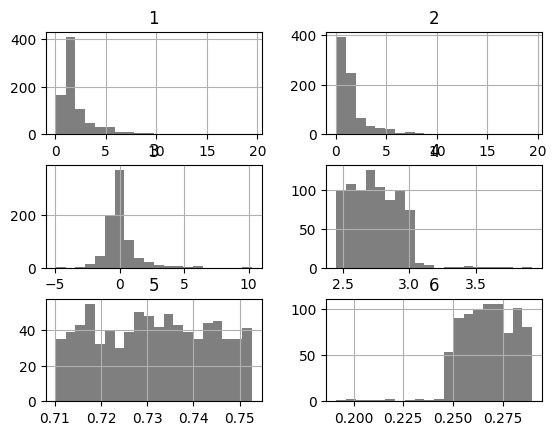

In [53]:
all_kpi[(np.abs(stats.zscore(all_kpi)) < 0.1).all(axis=1)].hist(color='k', alpha=0.5, bins=20)

In [65]:
all_kpi0[(np.abs(stats.zscore(all_kpi0)) < 3).all(axis=1)].hist(color='k', alpha=0.5, bins=20)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

array([[<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>],
       [<Axes: title={'center': '5'}>, <Axes: title={'center': '6'}>]],
      dtype=object)

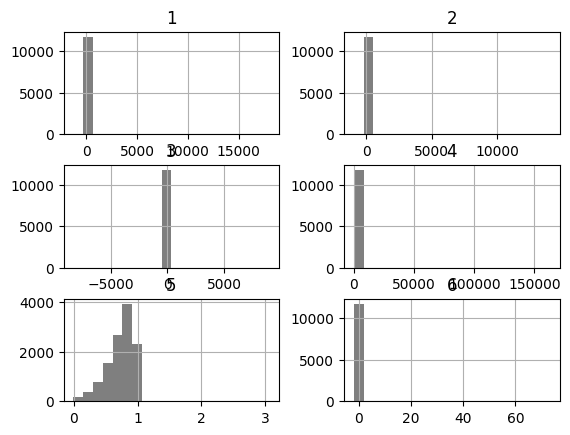

In [28]:
all_kpi.hist(color='k', alpha=0.5, bins=20)